# Analyze the data

We first import all the packages we need and load the data.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from great_tables import GT
# pysummaries allow us to generate beautufil summary tables!
# check it out at https://github.com/Genentech/pysummaries
from pysummaries import get_table_summary

# we have wrapped survival functions for easier use, look at survival_functions.py for more details
from survival_functions import generate_km_plot, calculate_coxph_hazard_ratio, calculate_cph_wald_tests_independent_covariates

Now, let's load the data and take a look at it.

In [2]:
# Read the data
data = pd.read_parquet("~/work/data/ard/patients.parquet")
data

,patient,progression,race,ethnicity,gender,income,age_at_dx,followup_neoplasm_months,followup_metastasis_months,is_dead,lines_of_treatment,death_reason
0,00b99a22-6749-4c13-b0f8-5d3957263377,in situ -> metastatic,white,nonhispanic,M,50.249,67,12.221766,9.264887,0,L1,Alive
1,00c9fc77-8956-e9f2-9637-ec1384e5e4f0,in situ,white,nonhispanic,M,126.045,63,10.809035,NaN,0,L2,Alive
2,00d0790e-25c5-25b8-b021-2a51dde140a0,in situ,white,nonhispanic,M,167.457,60,85.322382,NaN,0,L2,Alive
3,00ea3106-3410-65aa-5e07-84ee326e3432,in situ,other,nonhispanic,M,94.640,65,69.223819,NaN,0,L2,Alive
4,00f6f5e6-7f25-587e-1551-ee423dd0f22d,in situ,white,nonhispanic,M,323.357,69,9.232033,NaN,1,L2,Other causes
...,...,...,...,...,...,...,...,...,...,...,...,...
922,fe62a0ec-c6ef-0263-2f27-16cf717b77e2,in situ,white,nonhispanic,M,35.010,63,68.501027,NaN,0,L2,Alive
923,fe79f80d-341b-9f1b-9a97-065463a48329,in situ,white,nonhispanic,M,49.401,66,60.583162,NaN,1,L2,Other causes
924,ff0b9c41-268f-a33b-859e-6ad759708d79,in situ,white,nonhispanic,M,18.091,66,45.995893,NaN,0,L2,Alive
925,ff0cea11-dfe1-34f7-ee5d-d75622e5198e,in situ,white,nonhispanic,M,38.561,66,12.188912,NaN,0,L2,Alive


## Descriptive statistics

As a first step, we would like to compare descriptive statistics for the groups of interest, in this case the different progressions. We do this in order to identify potential differences between the groups that can affect our later analysis.


In [3]:
# A dictionary with the column names and their labels
column_labels = {'gender':'Gender, n (%)',
    'race':'Race, n (%)',
    'ethnicity': 'Ethnicity, n (%)',
    'age_at_dx':'Age at Dx (years)',
    'income': "Income (K USD)",
    'death_reason':'Death Reason, n (%)',
    'lines_of_treatment':'Lines of Treatment, n (%)',
}
# get the column names as a list
columns_include = list(column_labels.keys())
# get_table_summary will build a nice table with the descriptive statistics we need, stratified by progression
tone = get_table_summary(data, strata="progression", columns_include=columns_include, columns_labels=column_labels)
tone

,in situ -> metastatic (N=94),in situ (N=752),metastatic (N=81),Overall (N=927)
M,94 (100.0 %),752 (100.0 %),81 (100.0 %),927 (100.0 %)
white,83 (88.3 %),634 (84.3 %),65 (80.2 %),782 (84.4 %)
black,7 (7.4 %),62 (8.2 %),10 (12.3 %),79 (8.5 %)
other,4 (4.3 %),56 (7.4 %),6 (7.4 %),66 (7.1 %)
Missing,0 (0.0 %),0 (0.0 %),0 (0.0 %),0 (0.0 %)
nonhispanic,86 (91.5 %),675 (89.8 %),69 (85.2 %),830 (89.5 %)
hispanic,8 (8.5 %),77 (10.2 %),12 (14.8 %),97 (10.5 %)
Missing,0 (0.0 %),0 (0.0 %),0 (0.0 %),0 (0.0 %)
Mean (SD),67.6 (7.8),68.1 (8.6),66.6 (6.5),67.9 (8.4)
Median [Q1 ; Q3],65.0 [62.0 ; 71.0],65.0 [62.0 ; 71.0],65.0 [62.0 ; 68.0],65.0 [62.0 ; 71.0]


We see a small unbalance in the race, ethnicity and income. Those variables could be a source of bias and therefore we can try to control for them in our analysis. 

We also see that there is a big unbalance in the death reason, where a larger proportion of patients died due to prostatic cancer in those groups having metastasis. This is not very surprising, as having metastasis means the patient has a very agressive disease. As it is a consequence of the disease, rather than a cause, we should not control for it in our analysis.

Finally we also see that patients with in situ cancer have received always one or two lines of treatment, while patients with progression from in situ to metastasis have received only one line of therapy and patients with metastatic cancer have not received any treatment at all. This is an important observation that will help us our final recommendations.

## Survival Analysis for all progressions

Now, let's do a survival analysis dividing the patients by their progressions. We are first going to do a Kaplan-Meier plot to visualize the survival curves and calculate the median survival time for each group. 

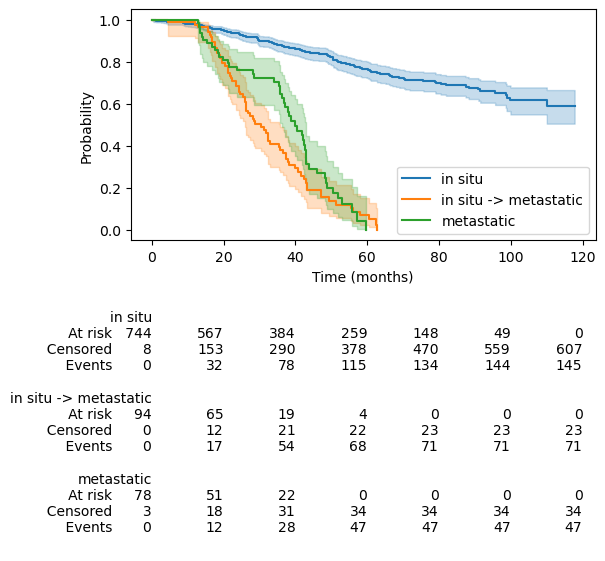

progression,median survival time (months)
in situ,inf (inf-inf)
in situ -> metastatic,30.5 (26.0-35.7)
metastatic,39.8 (36.2-42.9)


In [4]:
# generate_km_plot will generate the Kaplan-Meier plot and return the median survival times as a pandas dataframe
# If you would like to see how it was done, you can check the function in survival_functions.py
ax_overall, medsurv_overall = generate_km_plot(data,
        groupname="progression",
        eventname="is_dead",
        durationname="followup_neoplasm_months",
        )
plt.show()
# let's use the GT object to display the dataframe in a nicer way
GT(medsurv_overall)


From this plot, we can see that patients with in situ cancer have a very good survival, in 120 months (10 years) of followup, the population does not reach 50% of probability of death and therefore the median survival time cannot be calculated. Patients with metastatic cancer and progression from in situ to metastasis have a very poor survival, where those progressing from in situ to metastatic have a slightly worse survival. The confidence intervals of these two groups do not overlap suggesting that the difference is real. We will explore this further a bit later. 

Now, let's do a Cox proportional hazards regression to estimate the risk of death for each group, relative to the in situ group.

In [5]:
# calculate_coxph_hazard_ratio will calculate the hazard ratio using the Cox Proportional Hazard model
# it needs as input the data, the name of the column with the follow-up time, the name of the column with the event (death in this case)
# and a forumula, being the variable to stratify in this case
formula = "progression"
cox_result, coxph = calculate_coxph_hazard_ratio(data, "followup_neoplasm_months", "is_dead", formula,)
GT(cox_result)

variable,HR,conf. int. low,conf. int. high
progression[in situ -> metastatic],9.22,6.78,12.52
progression[metastatic],6.81,4.8,9.64


The in situ group was taken as baseline. The HR value for the two group with metastasis is larger than one and the confidence intervals do not cross 1, which indicates that the risk of death is higher for these two groups. The confidence intervals of these two groups do however do overlap, suggesting that the difference is not statistically significant.

Now, let's repeat this analysis, but controlling for race, ethnicity and income to check if those variables are affecting our results.

In [6]:
# To add the covariates, we can add them to the formula
formula = "progression+race+ethnicity+income"
cox_result, coxph = calculate_coxph_hazard_ratio(data, "followup_neoplasm_months", "is_dead", formula,)
GT(cox_result)

variable,HR,conf. int. low,conf. int. high
progression[in situ -> metastatic],9.33,6.86,12.69
progression[metastatic],6.77,4.77,9.61
race[black],1.07,0.7,1.61
race[other],0.77,0.45,1.32
ethnicity[hispanic],1.21,0.82,1.8
income,1.0,1.0,1.0


We see that the results for our progression groups are very similar to the previous analysis, while for all the other variables the confidence intervals cross 1, suggesting that they are not statistically significant. In order to test if race, ethnicity or income do have an effect on the survival, we conduct a wald test on those variables.

In [7]:
covariates = ['race', 'ethnicity','income',]
wald_tests = calculate_cph_wald_tests_independent_covariates(coxph, covariates)
GT(wald_tests)

Covariate,Wald statistic,Degrees of Freedom,p-value
race,1.04,2,0.593
ethnicity,0.9,1,0.342
income,0.61,1,0.435


The result of the wald test is not significant (p>0.05) for race, ethnicity or income, confirming that these variables do not have an effect in the survival.

## Survival Analysis for metastatic patients

In our previous analysis, we saw a difference in survival between patients with metastatic cancer and those with progression from in situ to metastasis. We will now focus on these two groups. 

In the previous analysis, we started the analysis at the time of the neoplasm diagnosis, as this time is available for all patients, including those with in situ cancer. In the metastatic cancer, the neoplasm diagnosis is the same as the metastasis diagnosis, however those progressing from in situ to metastasis first have a neoplasm diagnosis date and only later they are diagnosed with metastasis. This time difference can introduce a bias. To make a fair comparison therefore, we need to start the analysis at the time of the metastasis diagnosis for these two groups. 

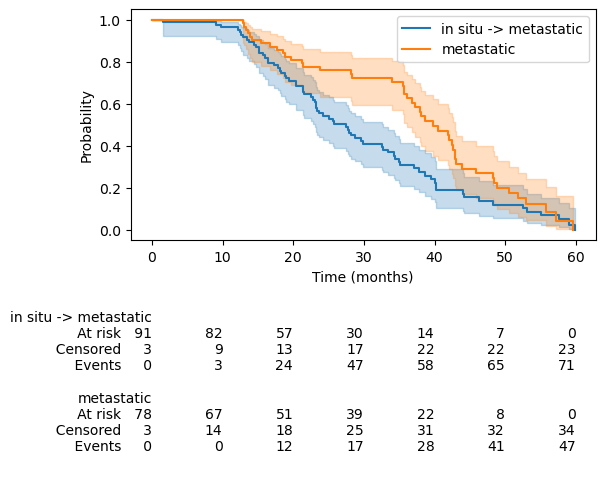

progression,median survival time (months)
in situ -> metastatic,27.5 (23.0-32.7)
metastatic,39.8 (36.2-42.9)


In [8]:
# select the patients that have progressed to metastatic disease and metastatic disease only
met_df = data.loc[data["progression"].isin(["in situ -> metastatic", "metastatic"])]
# run the function to get the Kaplan-Meier plot and the median survival times
ax_overall, medsurv_overall = generate_km_plot(met_df,
        groupname="progression",
        eventname="is_dead",
        durationname="followup_metastasis_months",
        )
plt.show()
GT(medsurv_overall)

The Kaplan-Meier curve looks similar as before, but the confiderence intervals have separated even a bit more. Let's do now the Cox proportional hazards regression to estimate the risk of death for each group, relative to the metastatic group. 

In [9]:
formula = "progression"
cox_result, coxph = calculate_coxph_hazard_ratio(met_df, "followup_metastasis_months", "is_dead", formula,)
GT(cox_result)

variable,HR,conf. int. low,conf. int. high
progression[metastatic],0.62,0.42,0.89


The HR value here is lower than one for the metastatic group, and the confidence intervals do not cross 1, confirming that the risk of death is lower for the metastatic group than for the group with progression from in situ to metastasis, or also that the risk of death for the progression group is higher than for the metastatic group.

## Survival Analysis for in situ patients

For those patients with in situ cancer, we will now evaluate if there is any difference in survival between those who received one line of therapy and those who received two lines of therapy.

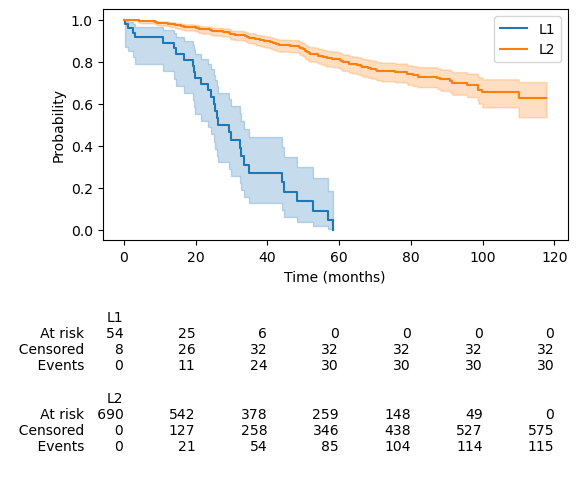

lines_of_treatment,median survival time (months)
L1,29.4 (23.4-33.4)
L2,inf (inf-inf)


In [10]:
# select the patients with in situ disease
insitu_df = data.loc[data["progression"]=="in situ"]
ax_overall, medsurv_overall = generate_km_plot(insitu_df,
        groupname="lines_of_treatment",
        eventname="is_dead",
        durationname="followup_neoplasm_months",
)
plt.show()
GT(medsurv_overall)

In this Kaplan-Meier plot we can see that there is a striking difference between these two groups, where those patients receiving only one line of treatment survive much shorter than those with two lines of treatment. 

Let's do now a Cox proportional hazards regression to estimate the risk of death for each group, relative to the group with one line of therapy.

In [11]:
formula = "lines_of_treatment"
cox_result, coxph = calculate_coxph_hazard_ratio(insitu_df, "followup_neoplasm_months", "is_dead", formula,)
GT(cox_result)

variable,HR,conf. int. low,conf. int. high
lines_of_treatment[L2],0.08,0.05,0.12


The HR value is lower than one for the group with two lines of therapy, and the confidence intervals do not cross 1, confirming that the risk of death is lower for the group with two lines of therapy than for the group with one line of therapy.